In [1]:
## Libraries


import os
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import seaborn as sns

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from torch.nn import Sequential

In [2]:
## Dataset

### Download

train_dataset = torchvision.datasets.MNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.MNIST('classifier_data', train=False, download=True)

# Datsets

print(train_dataset, "\n")
print(test_dataset)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 7386158.50it/s] 


Extracting classifier_data\MNIST\raw\train-images-idx3-ubyte.gz to classifier_data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 280062.46it/s]


Extracting classifier_data\MNIST\raw\train-labels-idx1-ubyte.gz to classifier_data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1585619.02it/s]


Extracting classifier_data\MNIST\raw\t10k-images-idx3-ubyte.gz to classifier_data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4544496.37it/s]

Extracting classifier_data\MNIST\raw\t10k-labels-idx1-ubyte.gz to classifier_data\MNIST\raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: classifier_data
    Split: Train 

Dataset MNIST
    Number of datapoints: 10000
    Root location: classifier_data
    Split: Test


Tuple: (<PIL.Image.Image image mode=L size=28x28 at 0x22F9EDFCEB0>, 5)

Image format: <PIL.Image.Image image mode=L size=28x28 at 0x22F9EE41670>

Sample at index: 0

Label: 7

Image:



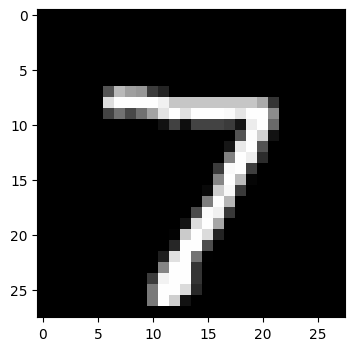

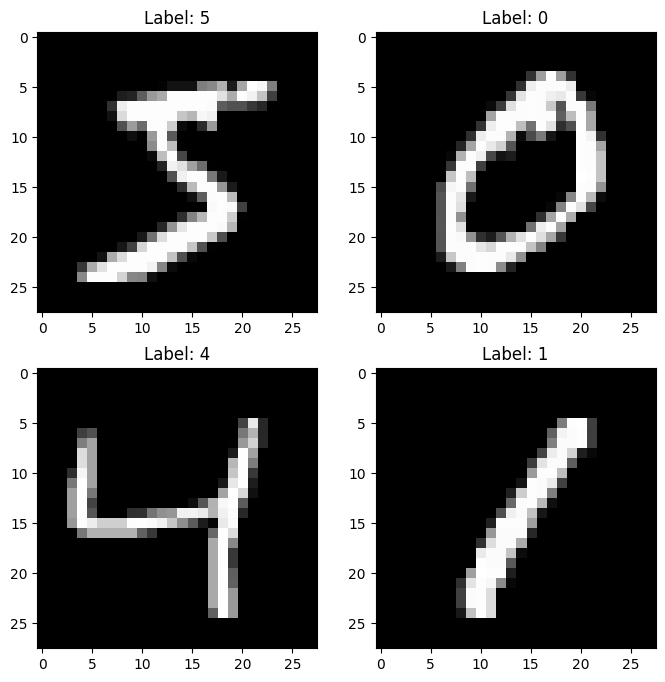

In [3]:
# How to get an image (PIL image) and the corresponding label

sample_index = 0
image = test_dataset[sample_index][0]
label = test_dataset[sample_index][1]

fig = plt.figure(figsize=(4,4))
plt.imshow(image, cmap='gist_gray')
print(f"Tuple:", train_dataset[sample_index])
print(f"\nImage format:", train_dataset[sample_index][0])
print(f"\nSample at index: {sample_index}")
print(f"\nLabel: {label}")
print("\nImage:\n")

# Some image samples

plt.figure(figsize=(8, 8))

for sample_index in range(4):
  im = train_dataset[sample_index][0]
  lab = train_dataset[sample_index][1]

  plt.subplot(2,2,sample_index+1)
  plt.title(f"Label: {lab}")
  plt.imshow(im, cmap='gist_gray')

In [4]:
"""### Data and splitting (train and validation sets)"""

# Tensor transformation of all dataset

train_trans = transforms.ToTensor()
test_trans = transforms.ToTensor()

train_dataset.transform = train_trans
test_dataset.transform = test_trans

In [5]:
# Training set
print(f"\nTensor shape: {train_dataset[sample_index][0].shape}")
print(f"\nTensor label at index {sample_index}: {train_dataset[sample_index][1]}")

# Test Set
print(f"\nTensor shape:", test_dataset[sample_index][0].shape)
print(f"\nTensor label at index {sample_index}: {test_dataset[sample_index][1]}")

# Split train (50000 samples) and validation set (10000 samples) 

torch.manual_seed(0)
train_dataset_new, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])

print(f"Train set length: {len(train_dataset_new)}")
print(f"\nValidation set length: {len(val_dataset)}")
print(f"\nTest set length: {len(test_dataset)}")
print(f"\nWhole train set for the train of the best model: {len(train_dataset)}")


Tensor shape: torch.Size([1, 28, 28])

Tensor label at index 3: 1

Tensor shape: torch.Size([1, 28, 28])

Tensor label at index 3: 0
Train set length: 50000

Validation set length: 10000

Test set length: 10000

Whole train set for the train of the best model: 60000


In [6]:
# Dataloader

train_dataloader = DataLoader(dataset=train_dataset, batch_size=50, shuffle=True,  num_workers=2)
train_dataloader_new = DataLoader(dataset=train_dataset_new, batch_size=50, shuffle=True,  num_workers=2)
validation_dataloader   = DataLoader(dataset=val_dataset,   batch_size=len(val_dataset),  shuffle=False, num_workers=2) 
test_dataloader  = DataLoader(dataset=test_dataset,  batch_size=len(test_dataset),  shuffle=False, num_workers=2)


In [7]:
# Dimension exploration of dataloaders

# Train batch
image_batch, label_batch = next(iter(train_dataloader_new))
print(f"\nTrain input batch shape: {image_batch.shape}")
print(f"Train label batch shape: {label_batch.shape}")

# Validation batch
image_batch, label_batch = next(iter(validation_dataloader))
print(f"\nValidation input batch shape: {image_batch.shape}")
print(f"Validation label batch shape: {label_batch.shape}")

# Test batch
image_batch, label_batch = next(iter(test_dataloader))
print(f"\nTest input batch shape: {image_batch.shape}")
print(f"Test label batch shape: {label_batch.shape}")

# Train batch (Whole train set)
print("\nTrain batch of the train set for the best model:")
image_batch, label_batch = next(iter(train_dataloader))
print(f"Train input batch shape: {image_batch.shape}")
print(f"Train label batch shape: {label_batch.shape}")


Train input batch shape: torch.Size([50, 1, 28, 28])
Train label batch shape: torch.Size([50])

Validation input batch shape: torch.Size([10000, 1, 28, 28])
Validation label batch shape: torch.Size([10000])

Test input batch shape: torch.Size([10000, 1, 28, 28])
Test label batch shape: torch.Size([10000])

Train batch of the train set for the best model:
Train input batch shape: torch.Size([50, 1, 28, 28])
Train label batch shape: torch.Size([50])


In [10]:
"""## Feed forward neural network (FFNN)

### Model
"""

class Net(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No, act_func, dropout): # Structure of the network, definition of the structural parameters
        """
        Ni - Input size
        Nh1 - Neurons in the first hidden layer
        Nh1 - Neurons in the second hidden layer
        No - Output size
        Activation function 
        Dropout probability
        """
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.act = act_func

        # Dropout
        self.dropout = nn.Dropout(dropout)

        
    def forward(self, x): 
        x = self.act(self.fc1(x)) 
        x = self.dropout(x)
        x = self.act(self.fc2(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

    
    def reset_weights(model):
        torch.manual_seed(0)
        for layer in model.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

In [12]:
# Training function FFNN

def train_function_FFNN(model, train_dataloader, validation_dataloader, num_epochs, optimizer, loss_function):
    """
    Input: model, train dataloader, validation dataloader, number of epochs, optimizer
    Output: list of (batch average) train losses (one for each epoch), list of (batch average) validation losses (one for each epoch)
    """
    torch.manual_seed(0)
    model.reset_weights() # Reset of the weights 
    
    train_loss_epochs = []
    accuracy_train_epochs = []
    
    val_loss_epochs = []
    accuracy_val_epochs = []

    for epoch_num in range(num_epochs):
      print(f'-> Epoch {epoch_num + 1}\n')

      # TRAIN
      train_loss= []
      accuracy_batch_train = []
      model.train() # Training mode 
      for sample_batched in train_dataloader:
        
        # Move data to device
        x_batch = sample_batched[0].to(FFNN_device)
        label_batch = sample_batched[1].to(FFNN_device)

        # Batch sample reshaping
        x_batch = x_batch.view(50, 1, 784) # From [50, 1, 28, 28] to [50, 1, 784]

        # Forward pass
        out = model(x_batch)

        # Output reshaping
        out = out.view(50, 10)  # From [50, 1, 10] to [50, 10]

        # Compute loss
        loss = loss_function(out, label_batch) 

        # Backpropagation
        model.zero_grad()
        loss.backward()

        # Update the weights
        optimizer.step()

        # Save train loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch) 

        # Prediction for training set
        softmax = torch.exp(out).cpu()
        prob = list(softmax.detach().numpy())
        predictions = np.argmax(prob, axis=1)

        # Save accuracy for this batch
        accuracy_batch_train.append(accuracy_score(label_batch.cpu(), predictions))

      # Save average train loss for this epoch
      train_loss = np.mean(train_loss) 
      print(f"Train loss: {train_loss}") 
      train_loss_epochs.append(train_loss) # List of the losses (= number of epochs) 

      # Save average accuracy for this epoch
      accuracy_batch_train = np.mean(accuracy_batch_train) 
      print(f"Accuracy on training set: {accuracy_batch_train}\n")
      accuracy_train_epochs.append(accuracy_batch_train) # List of the accuracies (= number of epochs) 
      

      # VALIDATION
      val_loss = []
      accuracy_batch_val = []
      model.eval()
      with torch.no_grad():
        for sample_batched in validation_dataloader: # If "batch_size=len(validation_dataset)" in validation_loder we have only one value (one iteration for the cycle)

            # Move data to device
            x_batch = sample_batched[0].to(FFNN_device)
            label_batch = sample_batched[1].to(FFNN_device)

            # Batch sample reshaping
            x_batch = x_batch.view(10000, 1, 784) # From [10000, 1, 28, 28] to [10000, 1, 784]

            # Forward pass
            out = model(x_batch)

            # Output reshaping
            out = out.view(10000, 10)  # From [10000, 1, 10] to [10000, 10]

            # Compute loss
            loss = loss_function(out, label_batch)

            # Save val loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)

            # Prediction for validation set
            softmax = torch.exp(out).cpu()
            prob = list(softmax.detach().numpy())
            predictions = np.argmax(prob, axis=1)

            # Save accuracy for this batch
            accuracy_batch_val.append(accuracy_score(label_batch.cpu(), predictions))
      
        # Save average validation loss for this epoch
        val_loss = np.mean(val_loss) # Validation loss calculated after each epoch
        print(f"Validation loss: {val_loss}") 
        val_loss_epochs.append(val_loss)

        # Save average accuracy for this epoch
        accuracy_batch_val = np.mean(accuracy_batch_val) 
        print(f"Accuracy on validation set: {accuracy_batch_val}\n")
        accuracy_val_epochs.append(accuracy_batch_val) # List of the accuracies (= number of epochs) 

    return train_loss_epochs, accuracy_train_epochs, val_loss_epochs, accuracy_val_epochs


In [13]:
"""### Optimizers

#### Adam
"""

class Adam_optimizer(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {} < 0".format(lr))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid parameter beta_1: {} not in [0; 1)".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid parameter beta_2: {} not in [0; 1)".format(betas[1]))
        if eps < 0.0:
            raise ValueError("Invalid epsilon value: {} < 0".format(eps))
        if weight_decay < 0:
            raise ValueError("Invalid weight_decay value: {} < 0".format(weight_decay))

        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super(Adam_optimizer, self).__init__(params, defaults)

    def step(self, closure=None):
        for group in self.param_groups:
            for params in group["params"]:
                if params.grad is None:
                    continue

                grad = params.grad.data
                # if grad.is_sparse:
                #     raise RuntimeError('We do not deal with sparse gradient.')     #do we need this check?
                
                state = self.state[params]
                if state.get('step', 0) == 0:
                    state['step'] = 0
                    state['m'] = torch.zeros_like(params.data)
                    state['v'] = torch.zeros_like(params.data)

                m = state['m']
                v = state['v']
                beta1, beta2 = group['betas']
                state['step'] += 1

                m = m * beta1 + (1 - beta1) * grad
                v = v * beta2 + (1 - beta2) * grad * grad

                m_hat = m / (1 - beta1 ** state['step'])
                v_hat = v / (1 - beta2 ** state['step'])

                params.data -= group['lr'] * m_hat / (v_hat.sqrt() + group['eps'])

                state['m'] = m
                state['v'] = v

        return None      # return loss = closure() but we don't use closure so it is None

"""#### Adagrad"""

class AdaGrad_optimizer(optim.Optimizer):
    def __init__(self, params, lr=1e-3, eps=1e-8, weight_decay=0, lr_decay=0.5):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {} < 0".format(lr))
        if eps < 0.0:
            raise ValueError("Invalid epsilon value: {} < 0".format(eps))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {} < 0".format(weight_decay))
        if lr_decay < 0.0:
            raise ValueError("Invalid lr_decay value: {} < 0".format(lr_decay))

        defaults = dict(lr=lr, eps=eps, weight_decay=weight_decay, lr_decay=lr_decay)
        super(AdaGrad_optimizer, self).__init__(params, defaults)

    def step(self, closure=None):
        for group in self.param_groups:
            for params in group["params"]:
                if params.grad is None:
                    continue

                grad = params.grad.data
                # if grad.is_sparse:
                #     raise RuntimeError('We do not deal with sparse gradient.')
                
                state = self.state[params]
                if state.get('step', 0) == 0:
                    state['step'] = 0
                    state['G'] = 0

                state['G'] += grad * grad
                state['step'] += 1

                params.data -= group['lr'] * grad / (state['G'] + group['eps']).sqrt()

        return None      # return loss = closure() but we don't use closure so it is None

"""### Random search"""

# Dict of lists of hyperparameters FFNN

hyperparam_grid_FFNN = {"Num_hidd_neurons": [64, 128], "Epochs":[30], "Act_func": [nn.ReLU(), nn.Sigmoid()],
              "Optimizer": [optim.Adam, optim.RMSprop], "lr": [0.001, 0.005],  "Regularizer_L2": [0, 0.001, 0.0001], "Dropout": [0, 0.3]}

# Random search FFNN

combinations_dict = ParameterGrid(hyperparam_grid_FFNN) # Combinations dict


In [17]:
# Sampling
from random import sample
torch.manual_seed(0)
samples = 25 # Number of samples (models) for random search
random_indeces = sample(range(0, len(combinations_dict)), samples) # Indeces to sample random combinations 
random_combinations_FFNN = [] # List of random combinations

for random_ind in random_indeces:
  random_combinations_FFNN.append(combinations_dict[random_ind])

scores_hyperpar_FFNN_models = [] # List of tuples with the score of the model and the set of hyperparameters for that score
number_combinations = len(random_combinations_FFNN) # Number of the all combinations
model_number = 1 # Counter for the grid search
FFNN_loss = nn.CrossEntropyLoss()

for hyperparam_combination in random_combinations_FFNN:

  FFNN = Net(784, hyperparam_combination["Num_hidd_neurons"], hyperparam_combination["Num_hidd_neurons"], 10, hyperparam_combination["Act_func"], hyperparam_combination["Dropout"])
  FFNN_device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # Check if the GPU is available
  FFNN.to(FFNN_device)
  optimizer = hyperparam_combination["Optimizer"](FFNN.parameters(), hyperparam_combination["lr"], weight_decay = hyperparam_combination["Regularizer_L2"])
  num_epochs = hyperparam_combination["Epochs"]

  print(f"\n\n##### MODEL: {model_number}/{number_combinations} #####\n")
  print("\nHyperparameters combination:\n", hyperparam_combination)
  model_number += 1
  train_loss, accuracy_train_scores, validation_loss, accuracy_val_scores = train_function_FFNN(FFNN, train_dataloader_new, validation_dataloader, num_epochs, optimizer, FFNN_loss)
  print("\n\n\nFINAL RESULT:")
  print(f"Final loss on validation set: {validation_loss[-1]}")
  print(f"Final accuracy on validation set: {accuracy_val_scores[-1]}")

  scores_hyperpar_FFNN_models.append((validation_loss[-1], accuracy_val_scores[-1], hyperparam_combination)) # Last validation, last accuracy and hyperparameters




##### MODEL: 1/25 #####


Hyperparameters combination:
 {'lr': 0.005, 'Regularizer_L2': 0.001, 'Optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'Num_hidd_neurons': 128, 'Epochs': 30, 'Dropout': 0.3, 'Act_func': ReLU()}
-> Epoch 1

Train loss: 0.5169405937194824
Accuracy on training set: 0.8442200000000001

Validation loss: 0.27936553955078125
Accuracy on validation set: 0.9146

-> Epoch 2

Train loss: 0.3367876410484314
Accuracy on training set: 0.89926

Validation loss: 0.22509604692459106
Accuracy on validation set: 0.9346

-> Epoch 3

Train loss: 0.31480225920677185
Accuracy on training set: 0.90722

Validation loss: 0.19595715403556824
Accuracy on validation set: 0.9408

-> Epoch 4

Train loss: 0.30356624722480774
Accuracy on training set: 0.9107000000000001

Validation loss: 0.18150995671749115
Accuracy on validation set: 0.9459

-> Epoch 5

Train loss: 0.29774871468544006
Accuracy on training set: 0.91244

Validation loss: 0.18320195376873016
Accuracy on validation set: 0.94

In [15]:
# Best model FNN

best_score_validation_FFNN = max(scores_hyperpar_FFNN_models, key=operator.itemgetter(1))[0]
best_score_accuracy_FFNN = max(scores_hyperpar_FFNN_models, key=operator.itemgetter(1))[1]
best_hyperpars_FFNN = max(scores_hyperpar_FFNN_models, key=operator.itemgetter(1))[2]
print("Best validation and accuracy score:\n", best_score_validation_FFNN, best_score_accuracy_FFNN)
print("\nBest hyperparameters:\n", best_hyperpars_FFNN)

"""### Testing """

# Training on the entire training dataset and testing on test set

FFNN_net = Net(784, best_hyperpars_FFNN["Num_hidd_neurons"], best_hyperpars_FFNN["Num_hidd_neurons"], 10, best_hyperpars_FFNN["Act_func"], best_hyperpars_FFNN["Dropout"])
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # Check if the GPU is available
FFNN_net.to(device)
optimizer = best_hyperpars_FFNN["Optimizer"](FFNN_net.parameters(), best_hyperpars_FFNN["lr"], weight_decay = best_hyperpars_FFNN["Regularizer_L2"])
num_epochs = 50

print("\n\n##### BEST MODEL TRAINING/TESTING #####\n")
train_losses, accuracy_train_scores, test_losses, accuracy_test_scores = train_function_FFNN(FFNN_net, train_dataloader, test_dataloader, num_epochs, optimizer, FFNN_loss)


Best validation and accuracy score:
 0.074805096 0.979

Best hyperparameters:
 {'lr': 0.001, 'Regularizer_L2': 0.0001, 'Optimizer': <class 'torch.optim.adam.Adam'>, 'Num_hidd_neurons': 128, 'Epochs': 30, 'Dropout': 0.3, 'Act_func': ReLU()}


##### BEST MODEL TRAINING/TESTING #####

-> Epoch 1

Train loss: 0.39745354652404785
Accuracy on training set: 0.8801166666666665

Validation loss: 0.16378885507583618
Accuracy on validation set: 0.9489

-> Epoch 2

Train loss: 0.1902245730161667
Accuracy on training set: 0.94335

Validation loss: 0.11308208107948303
Accuracy on validation set: 0.967

-> Epoch 3

Train loss: 0.15207356214523315
Accuracy on training set: 0.9542166666666666

Validation loss: 0.10039809346199036
Accuracy on validation set: 0.9695

-> Epoch 4

Train loss: 0.1297047883272171
Accuracy on training set: 0.9603333333333334

Validation loss: 0.08841131627559662
Accuracy on validation set: 0.9736

-> Epoch 5

Train loss: 0.1210361197590828
Accuracy on training set: 0.96221666


FINAL RESULT:
Final loss and accuracy for our model: (0.06262323, 0.9813)



C:\Users\Admin\AppData\Local\Temp\ipykernel_40020\1159796984.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


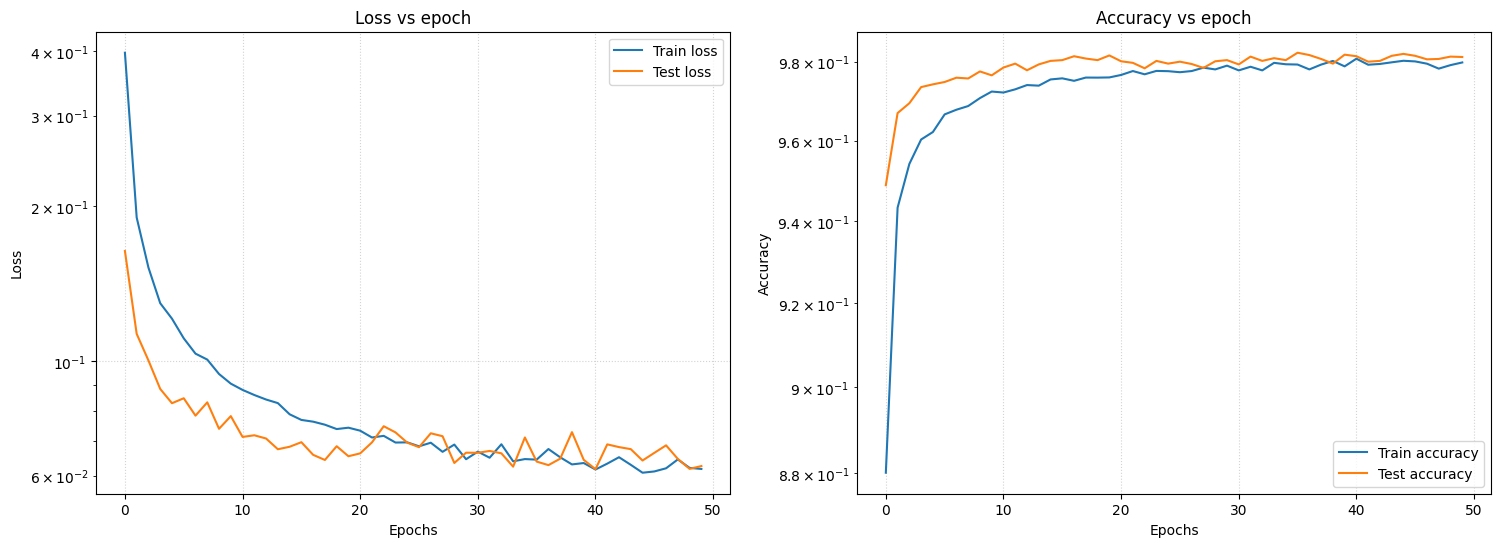

In [16]:
# Loss and accuracy plots

fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(18,6))
ax1.set_title("Loss vs epoch")
ax2.set_title("Accuracy vs epoch")
ax1.semilogy(train_losses, label='Train loss')
ax1.semilogy(test_losses, label='Test loss')
plt.semilogy(accuracy_train_scores, label='Train accuracy')
plt.semilogy(accuracy_test_scores, label='Test accuracy')
ax1.grid(color='lightgrey' , linestyle=':')
ax2.grid(color='lightgrey' , linestyle=':')
ax1.set_xlabel("Epochs")
ax2.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax2.set_ylabel("Accuracy")
ax1.legend()
ax2.legend()
fig.show()

print("\nFINAL RESULT:")
print(f"Final loss and accuracy for our model: {test_losses[-1], accuracy_test_scores[-1]}\n")